In [155]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

In [156]:
class LogEntry:
    def __init__(self, timestamp, level, message):
        self.timestamp = timestamp
        self.level = level
        self.message = message
    
    def __str__(self):
        return f"[{self.timestamp}] [{self.level}] {self.message}"

    @classmethod
    def from_line(cls, line):
        timestamp_str = line[1:28]
        timestamp = datetime.datetime.strptime(timestamp_str, '%Y-%b-%d %H:%M:%S.%f')
    
        level_start = line.find('] [') + 3
        level_end = line.find(']', level_start)
        level = line[level_start:level_end]
        
        message_start = level_end + 2
        message = line[message_start:].strip()

        return cls(timestamp, level, message)



def read_file(file_path):
    try:
        with open(file_path, 'r') as file:
            logs = []
            for line in file:
                try:
                    logs.append(LogEntry.from_line(line))
                except Exception as e:
                    pass
                    # print("Line couldn't be parsed:", e)
        return logs
    except FileNotFoundError:
        print(f"The file at {file_path} was not found.")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


In [157]:
class Transaction:
    def __init__(self, total, send, receive, processing):
        self.total = total
        self.send = send
        self.receive = receive
        self.processing = processing
        self.translation = total - send - receive - processing

    def __str__(self) -> str:
        return f"Total: {self.total}; sending {self.send}, receiving {self.receive}, processing {self.processing}"

    @classmethod
    def from_logs(cls, logs):
        total = logs[-1].timestamp - logs[0].timestamp
        send_start = []
        send_end = []
        receive_start = []
        receive_end = []
        processing_start = []
        processing_end = []
        for log in logs:
            if re.search("Transceiving...", log.message):
                send_start.append(log.timestamp)
            elif re.search("Transceive: Sent", log.message):
                send_end.append(log.timestamp)
            elif re.search("Synchronous receiving", log.message):
                receive_start.append(log.timestamp)
            elif re.search("Message received: ", log.message):
                receive_end.append(log.timestamp)
            elif re.search("Processing response", log.message):
                processing_start.append(log.timestamp)
            elif re.search("Response processed", log.message):
                processing_end.append(log.timestamp)
        
        send = sum(map(lambda tup: tup[1] - tup[0], zip(send_start, send_end)), datetime.timedelta())
        receive = sum(map(lambda tup: tup[1] - tup[0], zip(receive_start, receive_end)), datetime.timedelta())
        processing = sum(map(lambda tup: tup[1] - tup[0], zip(processing_start, processing_end)), datetime.timedelta())

        return cls(total, send, receive, processing)
    
    @classmethod
    def group_alf_logs(cls, logs):
        transactions = []
        begin = 0
        end = 0
        for i, log in enumerate(logs):
            if re.search("Received request", log.message):
                begin = i
            elif re.search("Request success", log.message):
                end = i+1
                transactions.append(Transaction.from_logs(logs[begin:end]))
        return transactions

```
[2024-Aug-29 17:15:42.446779] [info] Received request                                     ->     Request start
[2024-Aug-29 17:15:42.446982] [debug] Transceiving...                                     ->     Sending start
[2024-Aug-29 17:15:42.447027] [debug] Transceive: Send 1028 bytes                         ->     Sending end
[2024-Aug-29 17:15:42.447044] [debug] Synchronous receiving...                            ->     Receiving start
[2024-Aug-29 17:15:42.447547] [debug] Message received: 1028 bytes                        ->     Receiving end
[2024-Aug-29 17:15:42.447618] [debug] IO context called 2 times
[2024-Aug-29 17:15:42.447652] [debug] Transceive: Processing response                     ->     IPbus processing start
[2024-Aug-29 17:15:42.447691] [debug] Transceive: Response processed successfully         ->     IPbus processing end
[2024-Aug-29 17:15:42.448134] [info] Request successfully processed - sending response    ->     Request end
```

Run:

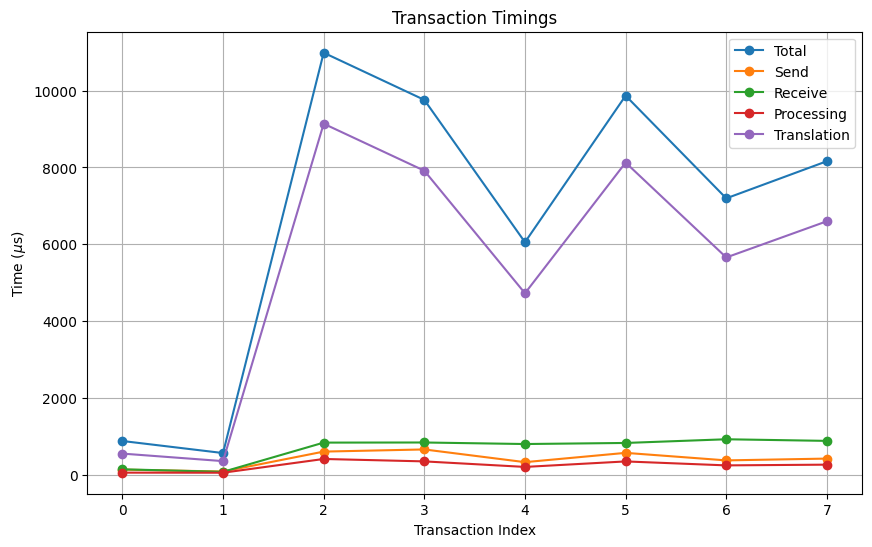

In [158]:
generator_logs = "log/analysis.txt"
generator_debug = True
alf_logs = "/home/flp/ALFIPbus/log/logs_mock_20240830164605.txt"
alf_debug = True

logs = read_file(alf_logs)
transactions = Transaction.group_alf_logs(logs)

# Data preparation
totals = [t.total.total_seconds() * 1e6 for t in transactions]
sends = [t.send.total_seconds() * 1e6 for t in transactions]
receives = [t.receive.total_seconds() * 1e6 for t in transactions]
processings = [t.processing.total_seconds() * 1e6 for t in transactions]
translations = [t.translation.total_seconds() * 1e6 for t in transactions]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(totals, label='Total', marker='o')
plt.plot(sends, label='Send', marker='o')
plt.plot(receives, label='Receive', marker='o')
plt.plot(processings, label='Processing', marker='o')
plt.plot(translations, label='Translation', marker='o')

plt.xlabel('Transaction Index')
plt.ylabel('Time ($\\mu$s)')
plt.title('Transaction Timings')
plt.legend()

plt.grid(True)
plt.show()
